## Bike Sharing Regression Assignment
Given the dataset on bike sharing, we will try and create a regression model to predict the variable cnt - the total number of rented bikes on a given day

#### Notebook sections

    1. Exploratory Data Analysis
    2. Data Preprocessing
    3. Model implementation
    4. Model assessment
    5. Final outcomes

In [1]:
#Importing the required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

In [2]:
# A function to retrieve the data types, null counts and number of unique values for each column in a Pandas DataFrame

def get_metadata(df):
    columns = []
    dtypes = []
    nulls = []
    unique_count = []
    for (col, dtype, null_count) in zip(df.columns, df.dtypes, df.isnull().sum()):
        columns.append(col)
        dtypes.append(dtype)
        nulls.append(null_count)
        unique_count.append(df[col].nunique())
    
    data = {"column_name":columns,"data_type":dtypes, "null_count":nulls, "unique_count":unique_count}
    df_metadata = pd.DataFrame(data)
    return df_metadata

In [3]:
def analyze_and_get_stats(X,y):
    #Fit the model
    lr = sm.OLS(y,X).fit()
    #Print the summary
    print(lr.summary())
    
    #Get the VIF scores
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    #Print VIF
    print(vif)

In [4]:
#Reading the data
df = pd.read_csv("data/day.csv")

### 1. Exploratory Data Analysis

In [5]:
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [6]:
df.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


Due to the nature of the columns instant and dteday, they will be dropped. instant is an identifier simply used for uniquely identifying rows and will, therefore have no bearing on the analysis. dteday has already been split into its components (yr, mnth and weekday).
As far as the columns casual and registered are concerned, they relate to our target variable by the following equation: casual+registered = cnt. Since these columns will never be available to us on the same day when we need to make the prediction, we cannot use them to build our model.

In [7]:
cols_to_drop = ['instant','dteday','casual','registered']
df = df.drop(cols_to_drop, axis = 1)

For the columns weathersit, weekday, season and mnth, we will change them back to the string values to which they were originally mapped because when we use them to create dummy variables later, it will make it easier to identify the column values. Yr has not been mapped again due to its binary nature. As and when more years data is added, it will be mapped apropriately.

In [8]:
weather_mapping = {1:'Clear', 2:'Mist', 3:'Light_Snow'}
df['weathersit'] = df['weathersit'].map(weather_mapping)

In [9]:
weekday_mapping = {0:"Sunday", 1:"Monday", 2:"Tuesday", 3:"Wednesday", 4:"Thursday", 5:"Friday", 6:"Saturday"}
df['weekday'] = df['weekday'].map(weekday_mapping)

In [10]:
season_mapping = {1:"spring", 2:"summer", 3:"fall", 4:"winter"}
df['season'] = df['season'].map(season_mapping)

In [11]:
month_mapping = {1:"Jan", 2:"Feb", 3:"Mar", 4:"Apr", 5:"May", 6:"Jun", 7:"Jul", 8:"Aug", 9:"Sept", 10:"Oct", 11:"Nov", 12:"Dec"}
df['mnth'] = df['mnth'].map(month_mapping)

In [13]:
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,spring,0,Jan,0,Saturday,0,Mist,14.110847,18.18125,80.5833,10.749882,985
1,spring,0,Jan,0,Sunday,0,Mist,14.902598,17.68695,69.6087,16.652113,801
2,spring,0,Jan,0,Monday,1,Clear,8.050924,9.47025,43.7273,16.636703,1349
3,spring,0,Jan,0,Tuesday,1,Clear,8.200000,10.60610,59.0435,10.739832,1562
4,spring,0,Jan,0,Wednesday,1,Clear,9.305237,11.46350,43.6957,12.522300,1600


In [14]:
df_meta = get_metadata(df)
df_meta

,column_name,data_type,null_count,unique_count
0,season,object,0,4
1,yr,int64,0,2
2,mnth,object,0,12
3,holiday,int64,0,2
4,weekday,object,0,7
5,workingday,int64,0,2
6,weathersit,object,0,3
7,temp,float64,0,498
8,atemp,float64,0,689
9,hum,float64,0,594


In [15]:
numerical = df_meta.loc[df_meta['unique_count'] > 12, 'column_name'].to_list()
df_numerical = df[numerical]
df_numerical.head()

,temp,atemp,hum,windspeed,cnt
0,14.110847,18.18125,80.5833,10.749882,985
1,14.902598,17.68695,69.6087,16.652113,801
2,8.050924,9.47025,43.7273,16.636703,1349
3,8.200000,10.60610,59.0435,10.739832,1562
4,9.305237,11.46350,43.6957,12.522300,1600


In [29]:
categorical = df_meta.loc[df_meta['unique_count'] <= 12, 'column_name'].to_list()
categorical.append('cnt')
df_categorical = df[categorical]

for col in df_categorical.columns:
    df_categorical[col].astype(str)

df_categorical.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,cnt
0,spring,0,Jan,0,Saturday,0,Mist,985
1,spring,0,Jan,0,Sunday,0,Mist,801
2,spring,0,Jan,0,Monday,1,Clear,1349
3,spring,0,Jan,0,Tuesday,1,Clear,1562
4,spring,0,Jan,0,Wednesday,1,Clear,1600


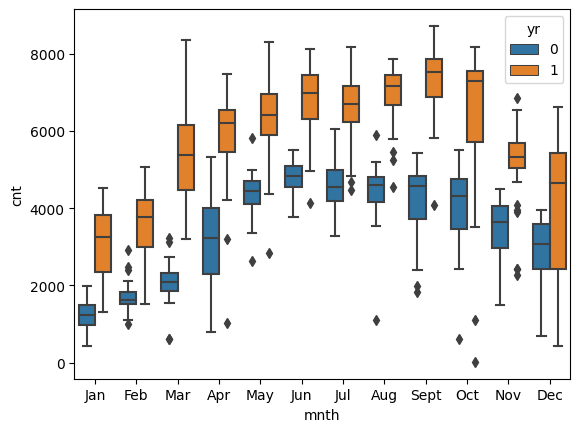

In [24]:
sns.boxplot(x='mnth',y='cnt',hue='yr',data=df_categorical)
plt.show()

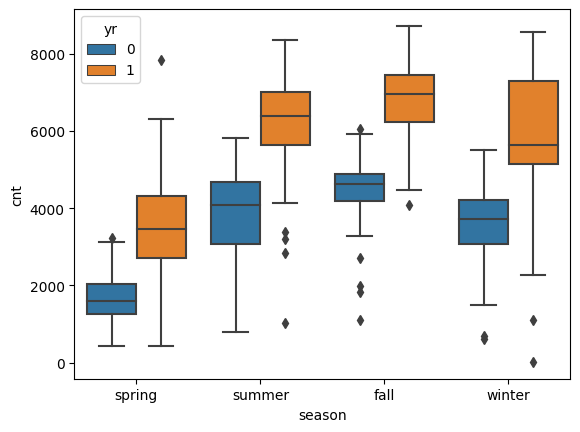

In [28]:
sns.boxplot(x='season',y='cnt',hue='yr',data=df_categorical)
plt.show()

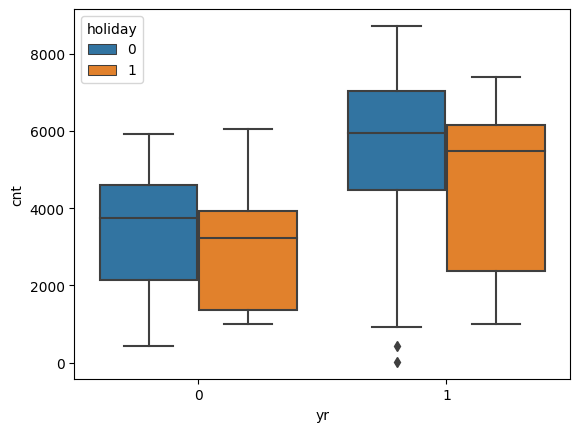

In [32]:
sns.boxplot(x='yr',y='cnt',hue='holiday',data=df_categorical)
plt.show()

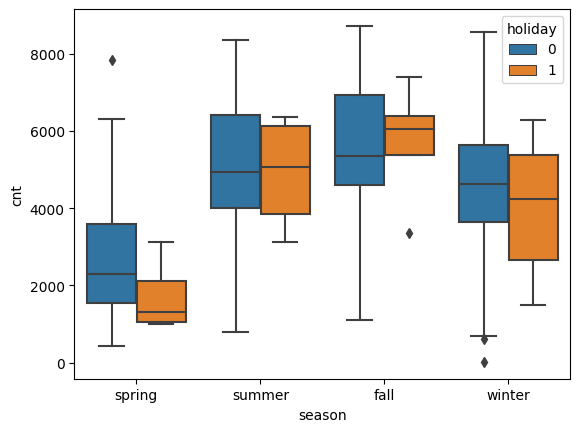

In [37]:
sns.boxplot(x='season',y='cnt',hue='holiday',data=df_categorical)
plt.show()

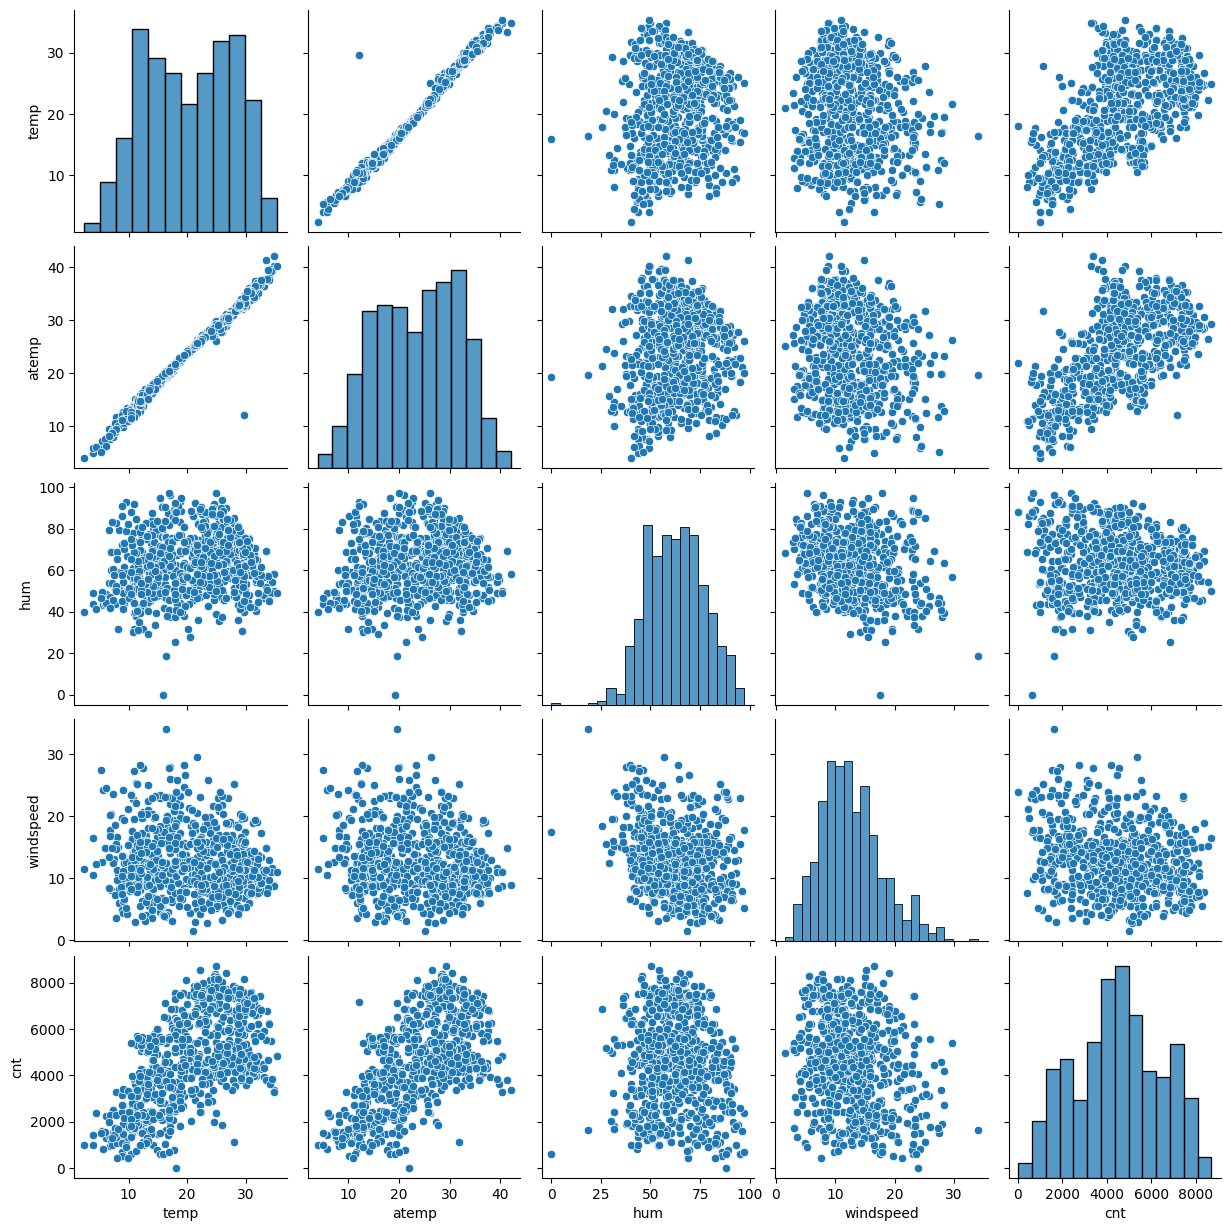

In [27]:
sns.pairplot(df_numerical)
plt.show()

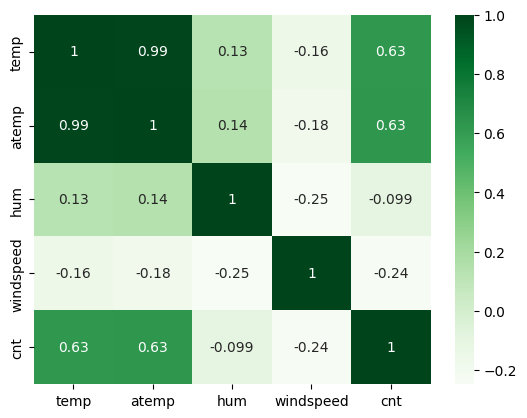

In [38]:
sns.heatmap(df_numerical.corr(), cmap = 'Greens', annot = True)
plt.show()

#### 2. Data Preprocessing

In [39]:
ohe = OneHotEncoder()

In [40]:
# Encoding non-binary categorical columns
df_categorical.drop('cnt', axis=1,inplace=True)
df_cat_meta = get_metadata(df_categorical)
df_cat_meta

C:\Users\abhir\AppData\Local\Temp\ipykernel_27256\1940210855.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_categorical.drop('cnt', axis=1,inplace=True)


,column_name,data_type,null_count,unique_count
0,season,object,0,4
1,yr,int64,0,2
2,mnth,object,0,12
3,holiday,int64,0,2
4,weekday,object,0,7
5,workingday,int64,0,2
6,weathersit,object,0,3


In [41]:
columns_to_encode = df_cat_meta.loc[df_cat_meta['unique_count'] > 2, 'column_name'].to_list()

In [42]:
dummy_cols = pd.get_dummies(df_categorical, drop_first=True, columns=columns_to_encode)

In [43]:
dummy_cols.head()

,yr,holiday,workingday,season_spring,season_summer,season_winter,mnth_Aug,mnth_Dec,mnth_Feb,mnth_Jan,...,mnth_Oct,mnth_Sept,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,weathersit_Light_Snow,weathersit_Mist
0,0,0,0,1,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,1
1,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
2,0,0,1,1,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
3,0,0,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,0,0,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [44]:
# Creating the final dataset with encoded columns
df_encoded = pd.concat([df_numerical,dummy_cols],axis=1)

In [45]:
df_encoded.head()

,temp,atemp,hum,windspeed,cnt,yr,holiday,workingday,season_spring,season_summer,...,mnth_Oct,mnth_Sept,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,weathersit_Light_Snow,weathersit_Mist
0,14.110847,18.18125,80.5833,10.749882,985,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
1,14.902598,17.68695,69.6087,16.652113,801,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
2,8.050924,9.47025,43.7273,16.636703,1349,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,0
3,8.200000,10.60610,59.0435,10.739832,1562,0,0,1,1,0,...,0,0,0,0,0,0,1,0,0,0
4,9.305237,11.46350,43.6957,12.522300,1600,0,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0


In [46]:
df_meta = get_metadata(df_encoded)
df_meta

,column_name,data_type,null_count,unique_count
0,temp,float64,0,498
1,atemp,float64,0,689
2,hum,float64,0,594
3,windspeed,float64,0,649
4,cnt,int64,0,695
5,yr,int64,0,2
6,holiday,int64,0,2
7,workingday,int64,0,2
8,season_spring,uint8,0,2
9,season_summer,uint8,0,2


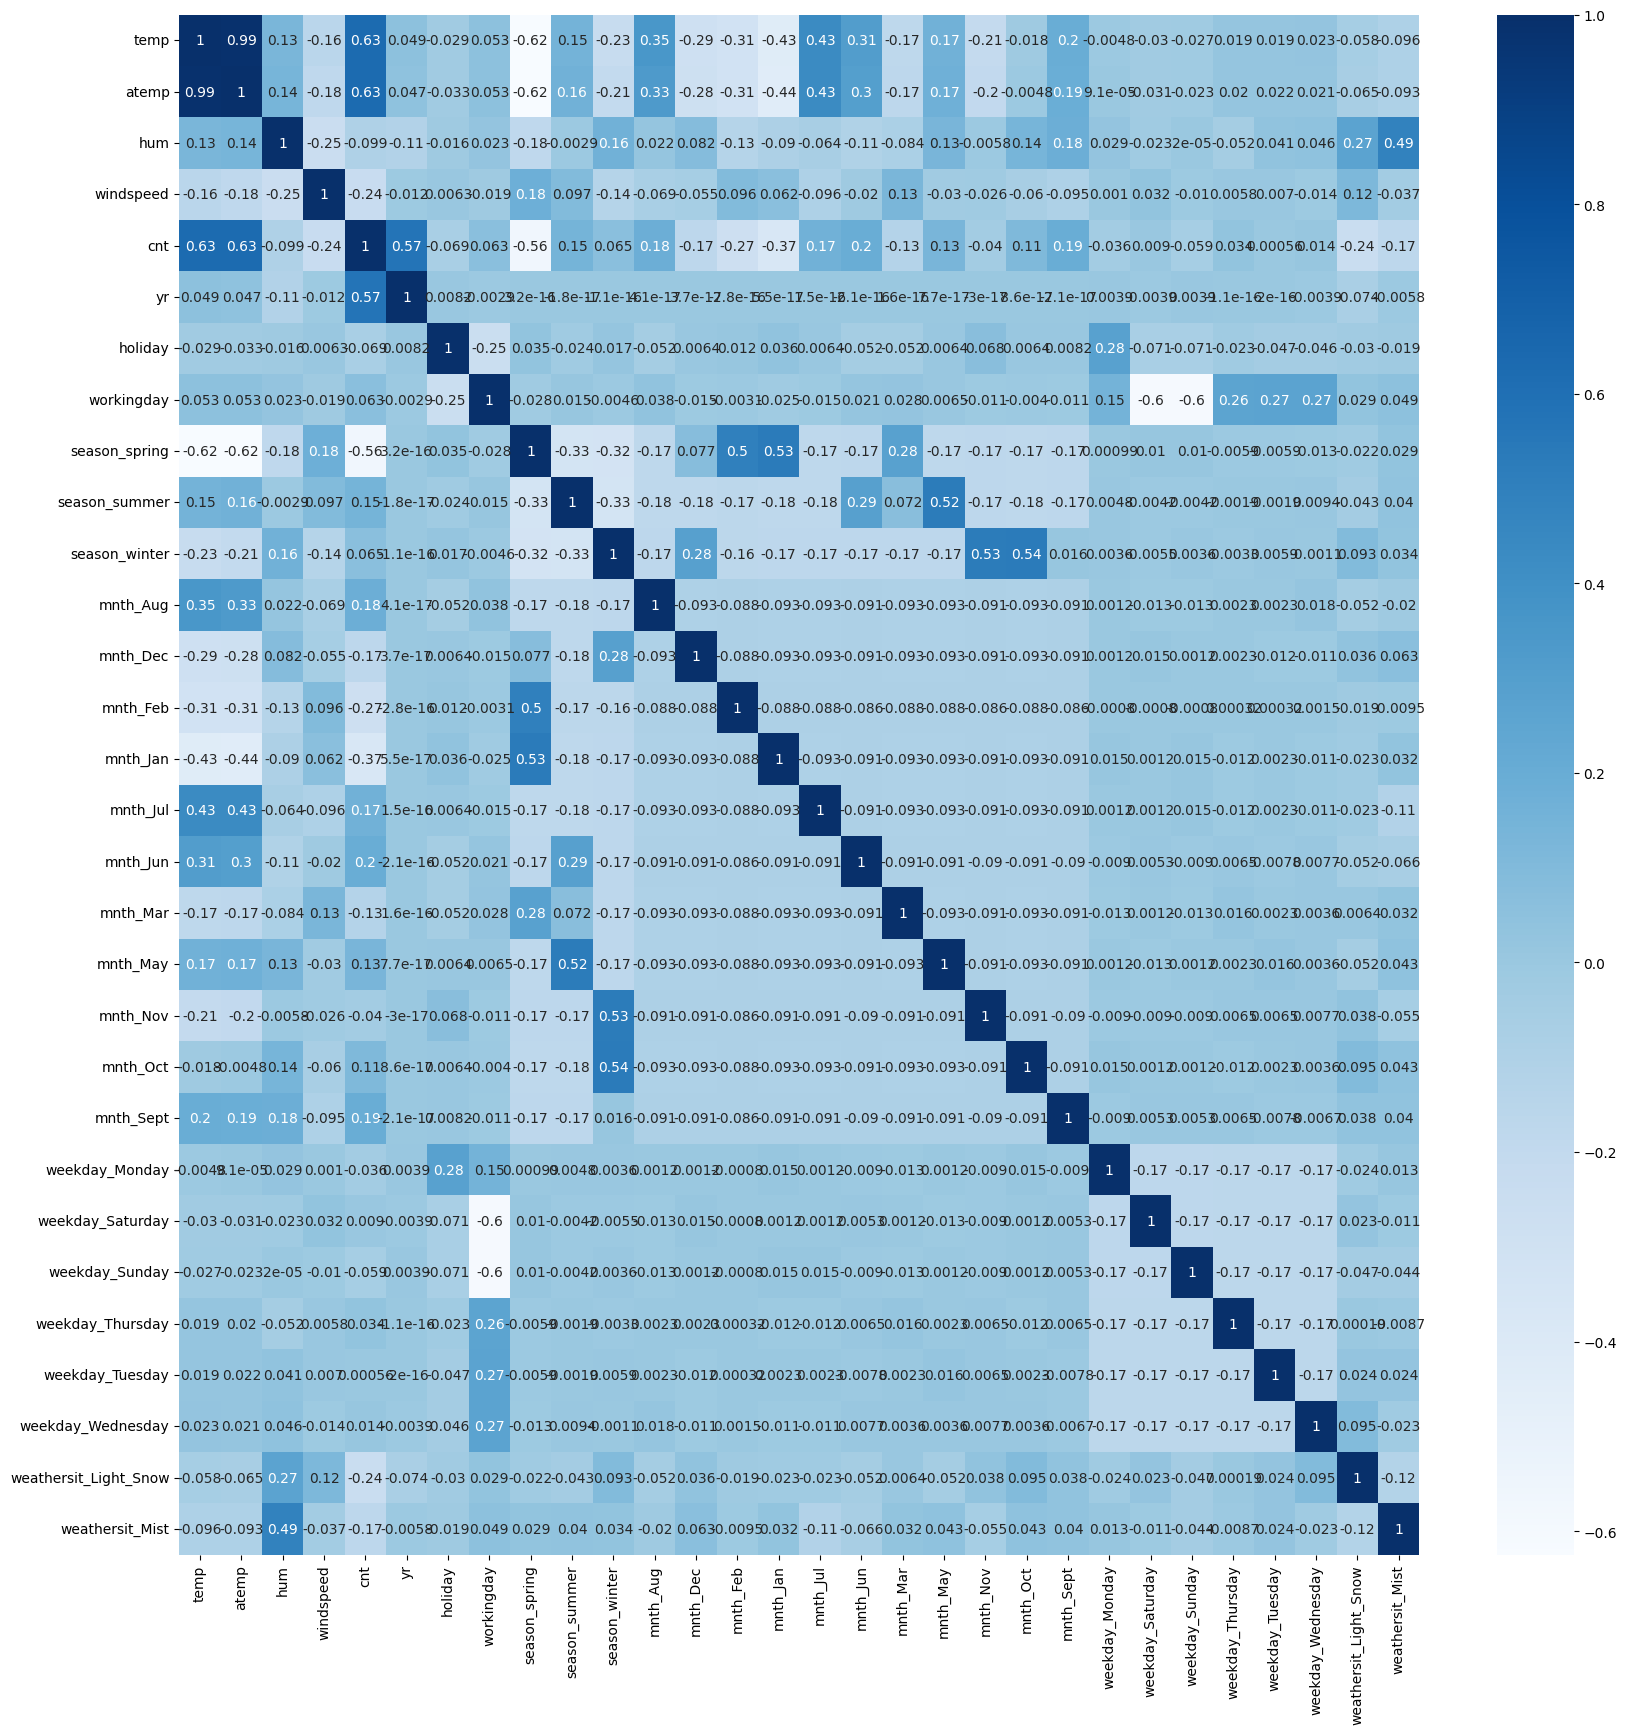

In [47]:
plt.figure(figsize=(20,20))
sns.heatmap(df_encoded.corr(), cmap='Blues',annot=True)
plt.show()

In [48]:
# Splitting the dataset into training and test sets
df_train, df_test = train_test_split(df_encoded,test_size=0.2)

In [49]:
scaler = MinMaxScaler()

In [50]:
# Choosing which numerical columns to scale using MinMaxScaler
columns_to_scale = df_meta.loc[df_meta['unique_count'] > 2, 'column_name'].to_list()
columns_to_scale

['temp', 'atemp', 'hum', 'windspeed', 'cnt']

In [51]:
# Scaling the continuous, numerical columns
df_train[columns_to_scale] = scaler.fit_transform(df_train[columns_to_scale])

In [52]:
df_train.describe()

,temp,atemp,hum,windspeed,cnt,yr,holiday,workingday,season_spring,season_summer,...,mnth_Oct,mnth_Sept,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,weathersit_Light_Snow,weathersit_Mist
count,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,...,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000
mean,0.548564,0.533669,0.644537,0.345340,0.522334,0.511986,0.027397,0.688356,0.246575,0.248288,...,0.087329,0.085616,0.140411,0.140411,0.143836,0.142123,0.147260,0.143836,0.027397,0.325342
std,0.225439,0.214621,0.144446,0.162286,0.223956,0.500285,0.163378,0.463562,0.431387,0.432390,...,0.282558,0.280037,0.347711,0.347711,0.351224,0.349476,0.354669,0.351224,0.163378,0.468904
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.354266,0.360075,0.539906,0.229511,0.370456,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.557133,0.553546,0.641816,0.325639,0.525311,1.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.743781,0.708173,0.749143,0.434936,0.696733,1.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [53]:
# Splitting into target and predictor sets
y_train = df_train.pop('cnt')
X_train = df_train

In [54]:
X_train.head()

,temp,atemp,hum,windspeed,yr,holiday,workingday,season_spring,season_summer,season_winter,...,mnth_Oct,mnth_Sept,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,weathersit_Light_Snow,weathersit_Mist
471,0.684333,0.695057,0.401457,0.517939,1,0,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0
687,0.400857,0.396830,0.640959,0.438441,1,0,1,0,0,1,...,0,0,1,0,0,0,0,0,0,1
716,0.438239,0.442443,0.685090,0.410274,1,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,0
488,0.708216,0.684928,0.756213,0.289744,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
217,0.819323,0.798987,0.776350,0.424388,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


#### Feature Selection

In [55]:
estimator = LinearRegression()
estimator.fit(X_train, y_train)

LinearRegression()

In [56]:
# Using RFE to narrow down the features from 30 to 15 in an automated manner
rfe = RFE(estimator, n_features_to_select=15)
rfe.fit(X_train, y_train)

RFE(estimator=LinearRegression(), n_features_to_select=15)

In [57]:
rfe_op = pd.DataFrame(list(zip(X_train.columns, rfe.support_, rfe.ranking_)), columns = ['column_name', 'rfe_support', 'rfe_ranking'])
rfe_op

,column_name,rfe_support,rfe_ranking
0,temp,True,1
1,atemp,True,1
2,hum,True,1
3,windspeed,True,1
4,yr,True,1
5,holiday,True,1
6,workingday,False,4
7,season_spring,True,1
8,season_summer,False,7
9,season_winter,True,1


In [58]:
# Choosing the columns selected by RFE
cols = rfe_op.loc[rfe_op['rfe_support'], 'column_name'].to_list()
cols

['temp',
 'atemp',
 'hum',
 'windspeed',
 'yr',
 'holiday',
 'season_spring',
 'season_winter',
 'mnth_Dec',
 'mnth_Jan',
 'mnth_Jul',
 'mnth_Nov',
 'mnth_Sept',
 'weathersit_Light_Snow',
 'weathersit_Mist']

<AxesSubplot: >

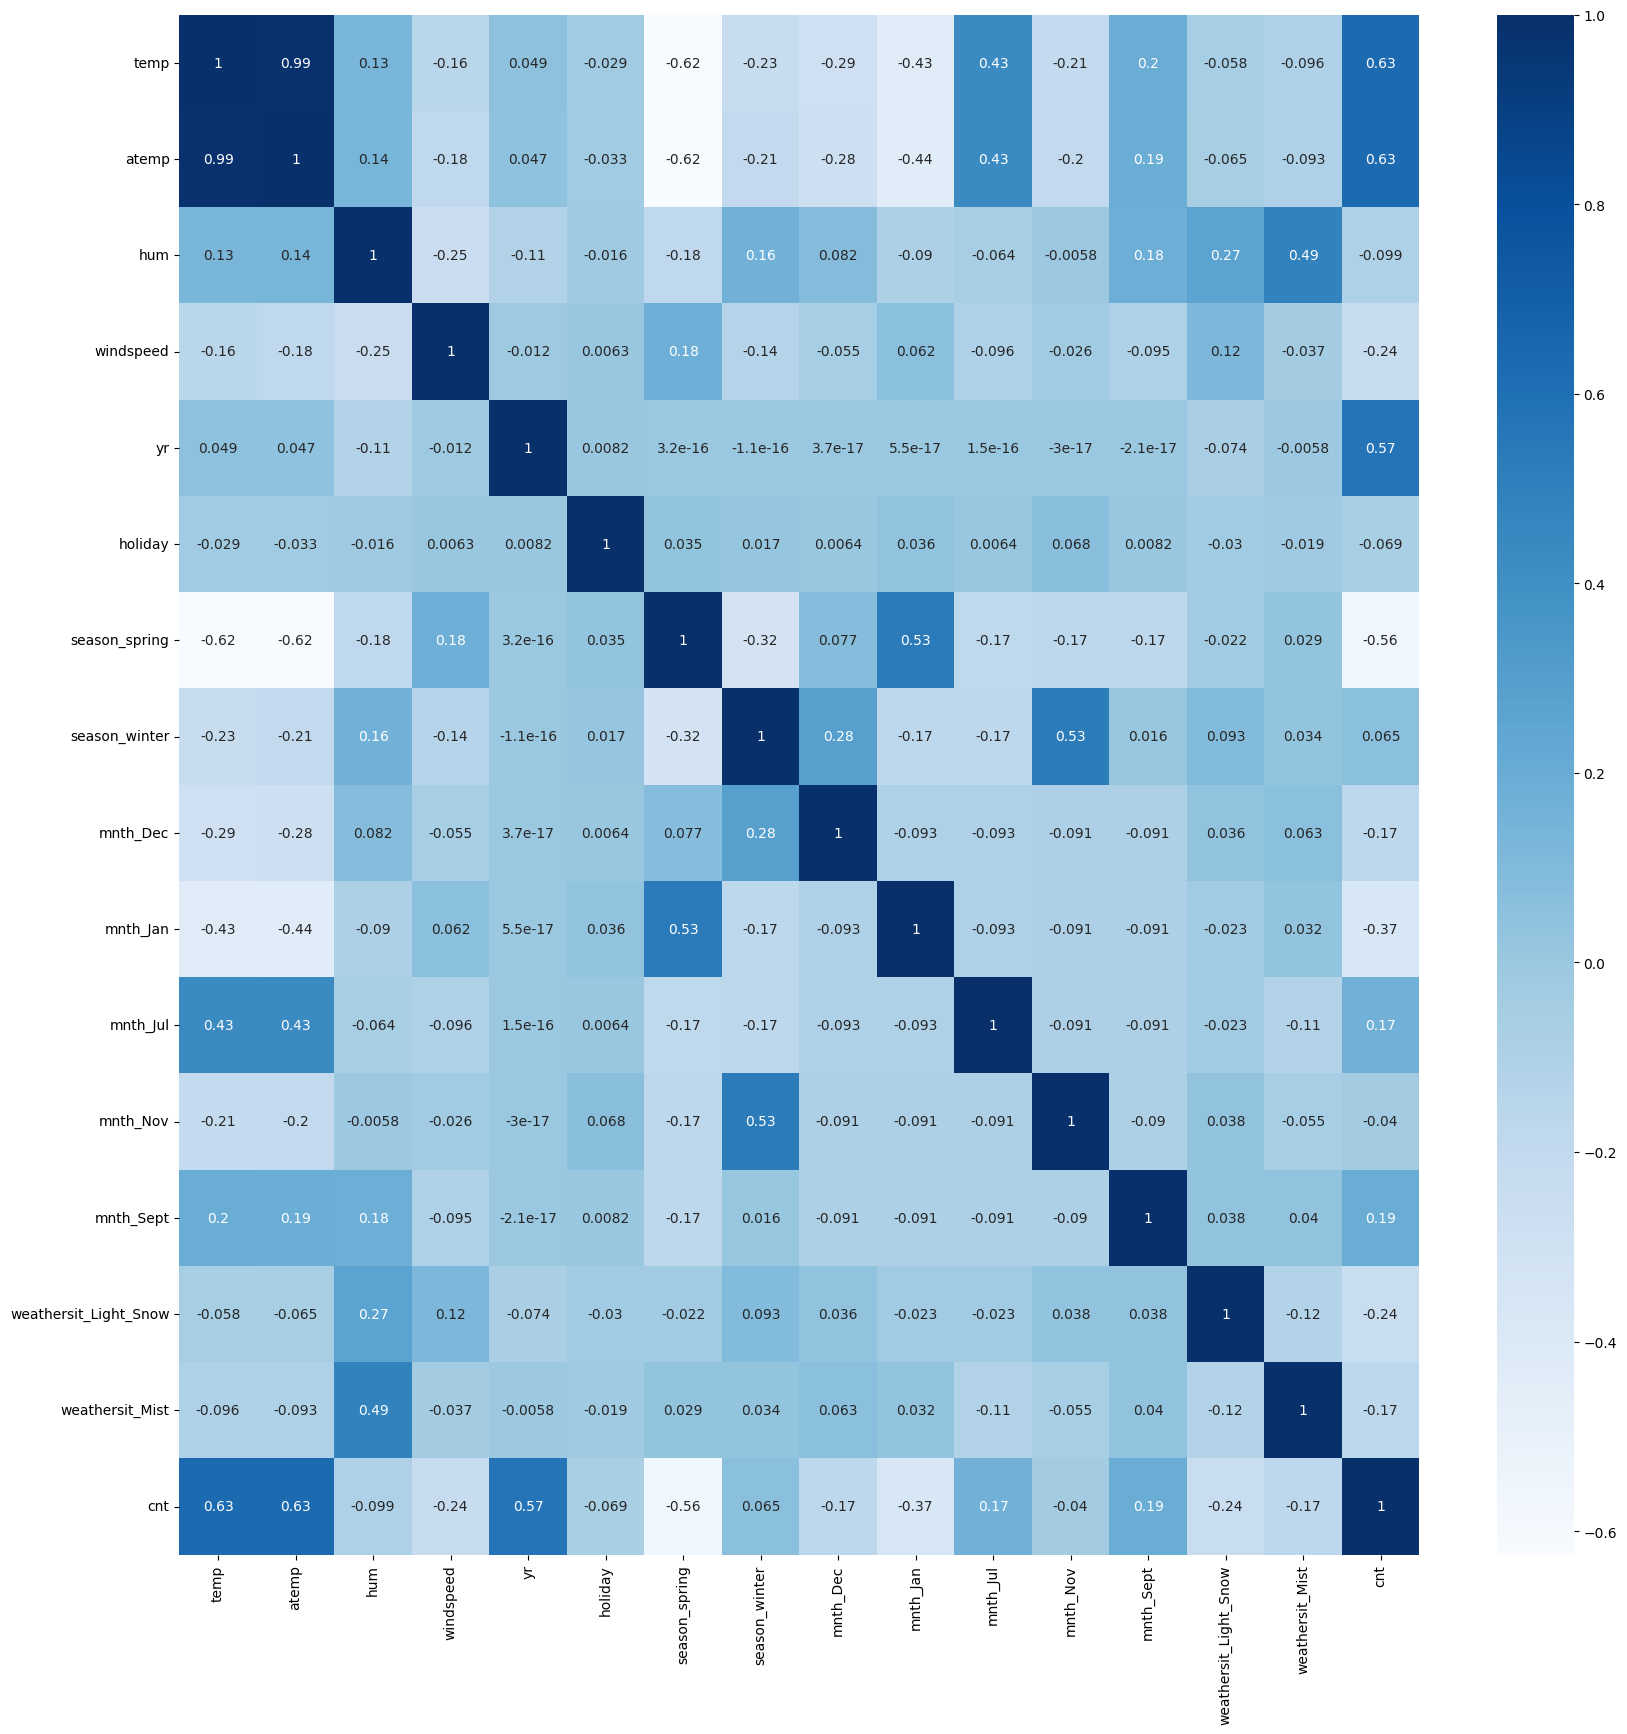

In [59]:
cols.append('cnt')
plt.figure(figsize=(20,20))
sns.heatmap(df_encoded[cols].corr(), cmap='Blues',annot=True)

In [64]:
#cols.remove('cnt')
X_train_rfe = X_train[cols]
X_train_sm = sm.add_constant(X_train_rfe)

#### 3. Model implementation

In [65]:
analyze_and_get_stats(X_train_sm,y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     202.2
Date:                Wed, 12 Jul 2023   Prob (F-statistic):          2.92e-216
Time:                        22:11:14   Log-Likelihood:                 584.90
No. Observations:                 584   AIC:                            -1138.
Df Residuals:                     568   BIC:                            -1068.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.37

In [66]:
# Removing atemp since it has a high VIF and high p-value
X_train_sm.drop('atemp', axis=1, inplace=True)
analyze_and_get_stats(X_train_sm,y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     216.2
Date:                Wed, 12 Jul 2023   Prob (F-statistic):          4.46e-217
Time:                        22:11:30   Log-Likelihood:                 584.05
No. Observations:                 584   AIC:                            -1138.
Df Residuals:                     569   BIC:                            -1073.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.37

In [67]:
# Removing mnth_Jan due to the high p-value
X_train_sm.drop('mnth_Jan', axis=1, inplace=True)
analyze_and_get_stats(X_train_sm,y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     230.7
Date:                Wed, 12 Jul 2023   Prob (F-statistic):          4.06e-217
Time:                        22:11:54   Log-Likelihood:                 581.32
No. Observations:                 584   AIC:                            -1135.
Df Residuals:                     570   BIC:                            -1073.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.36

In [68]:
# Fitting the final model and calculating residuals
lr = sm.OLS(y_train,X_train_sm).fit()
y_train_pred = lr.predict(X_train_sm)
res = y_train - y_train_pred

#### 4. Model evaluation

C:\Users\abhir\AppData\Local\Temp\ipykernel_27256\1482882585.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(res)


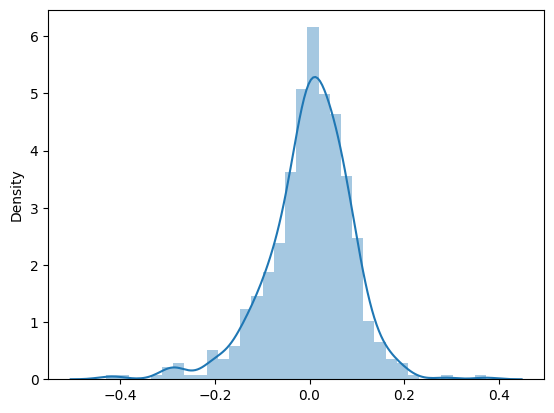

In [69]:
sns.distplot(res)
plt.show()

In [70]:
#Scaling the test set
df_test[columns_to_scale] = scaler.transform(df_test[columns_to_scale])

In [75]:
# Splitting it into target and predictor sets
y_test = df_test.pop('cnt')
cols = X_train_sm.columns.to_list()
cols.remove('const')
X_test = df_test[cols]
X_test = sm.add_constant(X_test)

In [76]:
X_test.head()

,const,temp,hum,windspeed,yr,holiday,season_spring,season_winter,mnth_Dec,mnth_Jul,mnth_Nov,mnth_Sept,weathersit_Light_Snow,weathersit_Mist
493,1.0,0.642799,0.765210,0.399983,1,0,0,0,0,0,0,0,0,1
301,1.0,0.243025,0.907455,0.678208,0,0,0,1,0,0,0,0,1,0
565,1.0,0.755981,0.868038,0.384635,1,0,0,0,0,1,0,0,0,1
170,1.0,0.717562,0.767352,0.274358,0,0,0,0,0,0,0,0,0,1
296,1.0,0.503656,0.793916,0.198734,0,0,0,1,0,0,0,0,0,0


In [77]:
y_test_pred = lr.predict(X_test)

In [78]:
r2 = r2_score(y_pred=y_test_pred, y_true=y_test)
r2

0.8225813838551391

In [80]:
# Getting residuals for the test set
res_test = y_test-y_test_pred

C:\Users\abhir\AppData\Local\Temp\ipykernel_27256\2856093868.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(res_test)


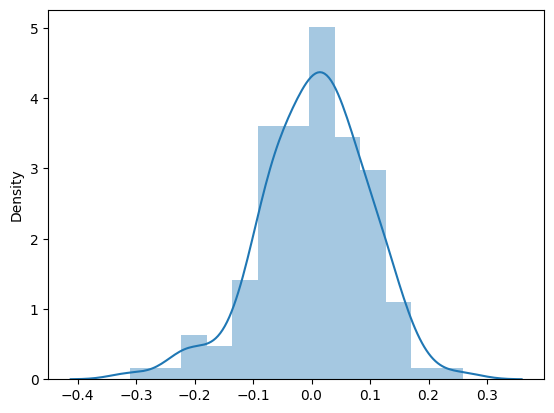

In [86]:
# Checking the distribution of residuals
sns.distplot(res_test)
plt.show()

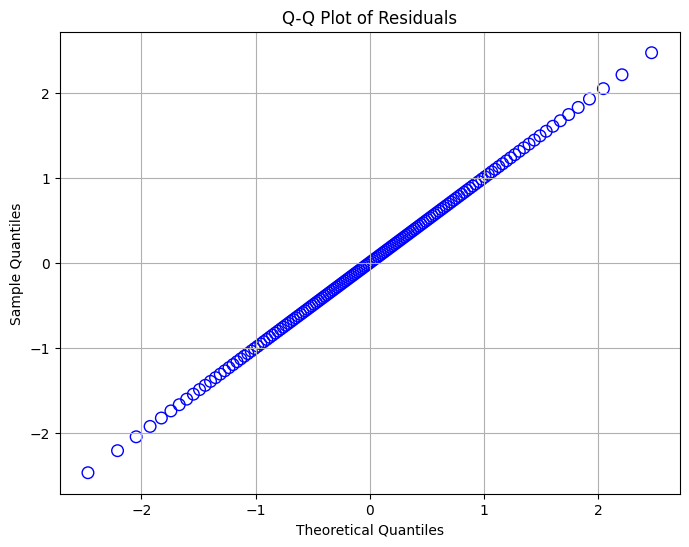

In [84]:
# Q-Q plot for test residuals
theoretical_quantiles = sm.ProbPlot(res_test).theoretical_quantiles

sorted_residuals = np.sort(res_test)
empirical_quantiles = sm.ProbPlot(sorted_residuals).theoretical_quantiles

plt.figure(figsize=(8, 6))
plt.scatter(theoretical_quantiles, empirical_quantiles, s=70, facecolors='none', edgecolors='blue')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.title('Q-Q Plot of Residuals')
plt.grid(True)
plt.show()

#### 5. Final Outcome

In [82]:
#Final model summary
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     230.7
Date:                Wed, 12 Jul 2023   Prob (F-statistic):          4.06e-217
Time:                        22:23:42   Log-Likelihood:                 581.32
No. Observations:                 584   AIC:                            -1135.
Df Residuals:                     570   BIC:                            -1073.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.3666      0.031     11.920      0.000       0.306       0.427
temp                      0.4575      0.030     15.418      0.000       0.399       0.516
hum                      -0.1767      0.035     -5.002      0.000      -0.246      -0.107
windspeed                -0.1635      0.025     -6.502      0.000      -0.213      -0.114
yr                        0.2330      0.008     30.543      0.000       0.218       0.248
holiday                  -0.0845      0.023     -3.661      0.000      -0.130      -0.039
season_spring            -0.1168      0.014     -8.283      0.000      -0.144      -0.089
season_winter             0.0705      0.013      5.561      0.000       0.046       0.095
mnth_Dec                 -0.0408      0.016     -2.576      0.010      -0.072      -0.010
mnth_Jul                 -0.0733      0.016     -4.627      0.000      -0.104      -0.042
mnth_Nov                 -0.0548      0.017     -3.164      0.002      -0.089      -0.021
mnth_Sept                 0.0604      0.014      4.241      0.000       0.032       0.088
weathersit_Light_Snow    -0.2090      0.026     -8.167      0.000      -0.259      -0.159
weathersit_Mist          -0.0498      0.010     -5.003      0.000      -0.069      -0.030
==============================================================================
Omnibus:                       87.871   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              228.042
Skew:                          -0.765   Prob(JB):                     3.03e-50
Kurtosis:                       5.651   Cond. No.                         19.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""